In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
temp1 = (calc_temps('2016-08-01', '2016-08-07'))
temp1

[(72.0, 77.79545454545455, 83.0)]

In [11]:
temp2 = (calc_temps('2015-08-01', '2015-08-07'))
temp2

[(69.0, 78.27272727272727, 85.0)]

In [12]:
temp3 = (calc_temps('2014-08-01', '2014-08-07'))
temp3

[(71.0, 77.45652173913044, 83.0)]

In [13]:
temp4 = (calc_temps('2013-08-01', '2013-08-07'))
temp4

[(69.0, 76.08163265306122, 81.0)]

### Average Temp to be expected is around 76-78 deg F in first week of Aug 

In [14]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [15]:
df = pd.DataFrame(temp1, columns =["tmin", "tavg", "tmax"])
df.loc[len(df.index)] = [69.0, 78.27272727272727, 85.0]
df.loc[len(df.index)] = [71.0, 77.45652173913044, 83.0]
df.loc[len(df.index)] = [69.0, 76.08163265306122, 81.0]
# df = df.append(pd.Series(temp2, index=df.columns[:len(temp2)]), ignore_index=False)
display(df)

,tmin,tavg,tmax
0,72.0,77.795455,83.0
1,69.0,78.272727,85.0
2,71.0,77.456522,83.0
3,69.0,76.081633,81.0


In [16]:
year = ['2016','2015','2014', '2013']
df["Year"] = year
df.set_index("Year", inplace = True)
df

,tmin,tavg,tmax
Year,,,
2016,72.0,77.795455,83.0
2015,69.0,78.272727,85.0
2014,71.0,77.456522,83.0
2013,69.0,76.081633,81.0


In [17]:
#Alternate Mathod to make DataFrame: 
data = [temp1, temp2, temp3, temp4]
#Flatten the list
norm_data = [item for sublist in data for item in sublist]
norm_data_df = pd.DataFrame(norm_data, columns = ["tmin", "tavg", "tmax"], index = year)
norm_data_df

,tmin,tavg,tmax
2016,72.0,77.795455,83.0
2015,69.0,78.272727,85.0
2014,71.0,77.456522,83.0
2013,69.0,76.081633,81.0


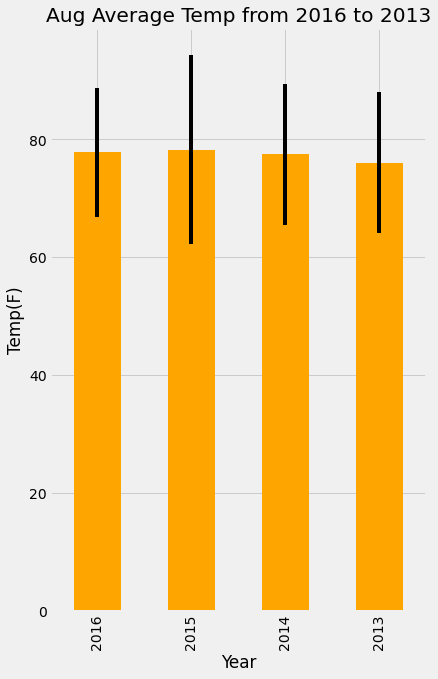

In [18]:
# plot the average temp 
plt.figure(figsize=(6,10))
ax=df["tavg"].plot.bar(yerr=(df["tmax"]-df["tmin"]), color="orange")
plt.title("Aug Average Temp from 2016 to 2013")
plt.ylabel("Temp(F)")
plt.xlabel("Year")
ax.axes.get_xaxis().set_visible(True)
plt.show()

### Daily Rainfall Average

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-08-01'
end_date = '2017-08-07'

sel = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]

rainfall=session.query(*sel).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(func.count(Measurement.prcp).desc()).all()

for r1 in rainfall:
    print(r1)

(7, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(6, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(3, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(3, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


### Daily Temperature Normals

In [20]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
vac_dates = ["2017-08-01", "2017-08-02", "2017-08-03", "2017-08-04", "2017-08-05", "2017-08-06", "2017-08-07"]

# Strip off the year and save a list of strings in the format %m-%d
vac_list = [datetime.strptime(date, "%Y-%m-%d") for date in vac_dates]
dates = [date.strftime("%m-%d") for date in vac_list]
dates

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [22]:
 #Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
dates = ['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']
normals = [daily_normals(date) for date in dates]
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [23]:
# flatten the normals list
normal_list = [item for sublist in normals for item in sublist]
normal_list

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normal_list, columns=["tmin","tavg", "tmax"], index=vac_dates)
normals_df.index.name="date"
normals_df

,tmin,tavg,tmax
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


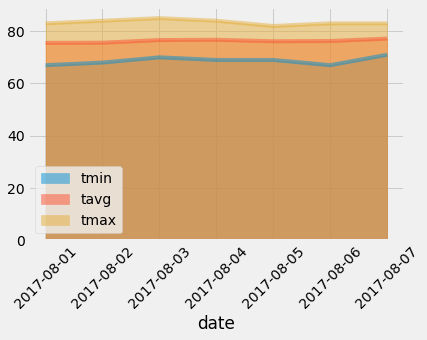

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.show()

## Close Session

In [26]:
session.close()